# YouTube Comment Analysis (w/ Sentiment Analysis)

## Initial Imports/Data Validation and Cleaning

In [ ]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

df = pd.read_csv("data/comments_df_11-4-2022.csv")
df.head()

,Video Id,text,time,displayID,id
0,DOtPOfeyJ4Q,"Don't send it back. This video is a gem. Bro, ...",2022-11-04T15:41:35Z,Tim Gibson,UC8DCyaImyGP2jrJOdD64Efg
1,DOtPOfeyJ4Q,Hes not scamming his sister probably got it fo...,2022-11-04T15:04:13Z,The guy who asked,UCNijoEJw5z3p4689tey5oYw
2,DOtPOfeyJ4Q,He offered your money back definitely not a sc...,2022-11-04T14:57:57Z,F.B.I,UCXbuhDqmdm_M8UEOrQ77w6w
3,DOtPOfeyJ4Q,Isn’t it hard authenticate a signature. If Kob...,2022-11-04T14:54:47Z,Olti Hajdaraj,UCPOYMbZKAIN39YFsvMTZ-Uw
4,DOtPOfeyJ4Q,"He answered the phone, definitely not trying t...",2022-11-04T14:49:10Z,Jordan,UCga1Isau1iPAlrezA6xoYSQ


In [4]:
# What datatypes are present and are there missing value/null values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58561 entries, 0 to 58560
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Video Id   58561 non-null  object
 1   text       58559 non-null  object
 2   time       58561 non-null  object
 3   displayID  58555 non-null  object
 4   id         58561 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [5]:
# Renaming text column to comment
df.rename({'text' : 'comment'} , axis = 1 , inplace = True)

I decided to drop the null/missing values rather than impute them because they don't represent a large portion of the dataset.

In [6]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58553 entries, 0 to 58560
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Video Id   58553 non-null  object
 1   comment    58553 non-null  object
 2   time       58553 non-null  object
 3   displayID  58553 non-null  object
 4   id         58553 non-null  object
dtypes: object(5)
memory usage: 2.7+ MB


In [7]:
# Converting date to a datetime
df['time'] = pd.to_datetime(df['time'])
df.dtypes

Video Id                  object
comment                   object
time         datetime64[ns, UTC]
displayID                 object
id                        object
dtype: object

In [8]:
# Creating for discrete hour , day of the week , month , and year
df['discrete_hour'] = df['time'].dt.hour
df['discrete_dow'] = df['time'].dt.dayofweek
df['discrete_month'] = df['time'].dt.month
df['discrete_year'] = df['time'].dt.year

## Data Exploration

### Visualizing 14-day Moving Average for number of comments

In [9]:
# Resampling comments daily and using a 14 day moving average to smooth the comment count
df_copy = df.copy()
df_copy['count'] = 1
df_copy = df_copy.set_index('time').resample('1D').sum().rolling(14).mean()

# Subsetting to start in January 2022
df_copy = df_copy.loc['2022-01-01 00:00:00+00:00':]

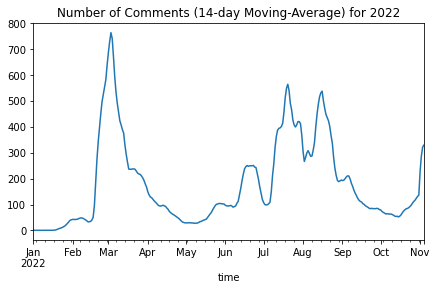

In [14]:
# Creating a linechart to chow the trend over time
plt.figure(figsize = (7, 4))
df_copy['count'].plot()
plt.title('Number of Comments (14-day Moving-Average) for 2022' , size = 12);

### What times of the day do people comment the most?

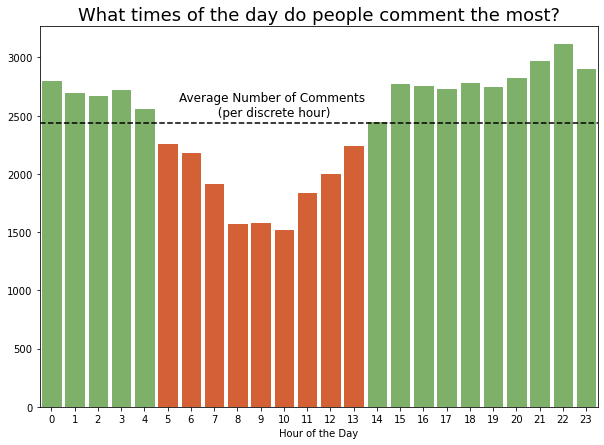

In [15]:
# Grouping the data by discrete hour
df_grouped_hour = df.groupby('discrete_hour')['id'].size()
avg_comments_per_hour = np.mean(df_grouped_hour.values)

# Quick bar chart to visualize the trend
plt.figure(figsize = (10, 7))
ax = sns.barplot(x  = df_grouped_hour.index  , y = df_grouped_hour.values)

# Setting the color of each bar
for bar in ax.patches:
    if bar.get_height() > avg_comments_per_hour:
        bar.set_color('#7FB069')    
    else:
        bar.set_color('#D36135')

# The dotted horizontal line represents the average across all hours
plt.axhline(y = np.mean(df_grouped_hour.values) , color = 'black' , linestyle = '--')
plt.text(5.5,2500,'Average Number of Comments \n          (per discrete hour)' , size = 12)
plt.title('What times of the day do people comment the most?' , size = 18)
plt.xlabel('Hour of the Day');

Most comments come in the early morning or afternoon/night (after 1 PM). It's surprising to see that the period from 5AM-1PM is not more active but this might be because users are at school/work.

### What day of the week do people comment the most?

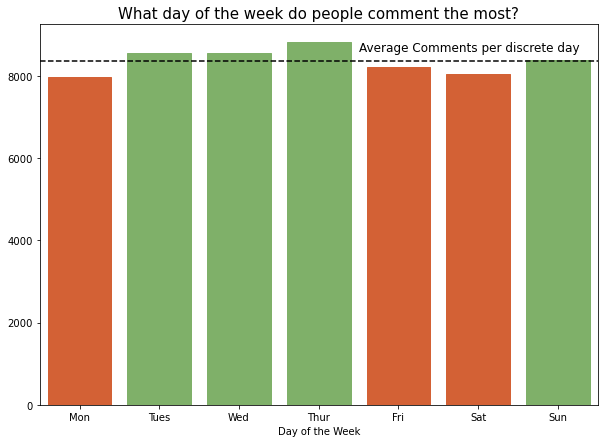

In [22]:
# Grouping the data by discrete dow
df_grouped_dow = df.groupby('discrete_dow')['id'].size()
avg_comments_per_day = np.mean(df_grouped_dow.values)

# Quick bar chart to visualize the trend
plt.figure(figsize = (10, 7))
ax = sns.barplot(x  = df_grouped_dow.index  , y = df_grouped_dow.values)

# Setting the color of each bar
for bar in ax.patches:
    if bar.get_height() > avg_comments_per_day:
        bar.set_color('#7FB069')    
    else:
        bar.set_color('#D36135')

# The dotted horizontal line represents the average across all hours
plt.axhline(y = avg_comments_per_day , color = 'black' , linestyle = '--')
plt.text(3.5,8600,'Average Comments per discrete day' , size = 12)
plt.title('What day of the week do people comment the most?' , size = 15)
plt.xlabel('Day of the Week')
plt.xticks(ax.get_xticks() , labels = ['Mon' , 'Tues' , 'Wed' ,'Thur' , 'Fri' , 'Sat' , 'Sun']);

Comments are distributed relatively uniformly across days.

## Sentiment Analysis

### Text cleaning

Knowing that comments can vary greatly in length, the first step I decided to take is to take a look at the distribution of how many words were in each comment.

In [23]:
# Creating a function to count number of "words" by splitting comments by spaces.. 'words' in this case can mean any characters seperated by a space.
def comment_length(comment):
    return len(comment.split(' '))

df['comment_length'] = df['comment'].apply(comment_length)

Text(0.5, 1.0, 'Distribution of comment lengths')

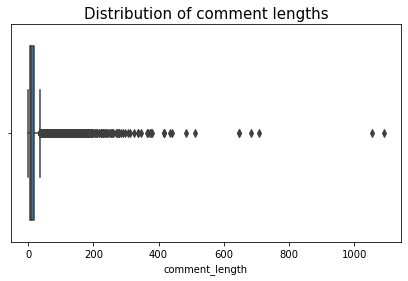

In [25]:
# Creating a boxplot to visualize the number of "words" when splitting by spaces
plt.figure(figsize = (7, 4))
sns.boxplot(x = 'comment_length' , data = df)
plt.title('Distribution of comment lengths' , size = 15)

Most of the comments have less than 100 words but there are many outliers that I won't be using with sentiment analysis. I decided to use the 95th percentile as a cutoff point to get rid of the extremely long comments.

In [26]:
# Finding the 95th percentile for comment length
comment_len_95_percentile = int(np.percentile(df.comment_length , 95))
print(f'The 95th percentile for comment length is {comment_len_95_percentile} words')

The 95th percentile for comment length is 43 words


In [27]:
# Subseting the data to comments <= 43 words long
df = df[df['comment_length'] <= comment_len_95_percentile]
df.shape

(55709, 10)

### Predicting Senitment and Calulating Confidence Scores

#### Bringing in / configuring the pipeline for calculating sentiment

In [10]:
# The model that will be used to calculate sentiment
pipe = pipeline(model = 'cardiffnlp/twitter-roberta-base-sentiment-latest')
pipe.tokenizer.model_max_length=256

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
# Import tqdm to monitor progress
from tqdm import tqdm

# Creating a list of all comments in the dataset to pass through the pipeline
comments_list = df.comment.tolist()

# Instantiate an empty list to store pipeline results
sentiment_dicts = [] 

# Itereating over the comments , passing each through the pipeline and appending the result dictionary to sentiment_dicts
for comment in tqdm(comments_list , total = len(comments_list)):
    try:
        sentiment_dicts.append(pipe(comment))
    except:
        sentiment_dicts.append([{'label' : 'Not Provided', 'score': 'Not Provided'}])
        print(comment)

  9%|██████▊                                                                      | 4954/55709 [02:53<30:01, 28.17it/s]

Me: *makes Nokia spinner*
FBI:  W̴͔̏̕E̵̪͐̌̕ͅ W̴͔̏̕A̶̤͍̟̲͓͕͍̼͕͎̽́̒̇͝N̶͎̫̉̍͘͝T̷̢̧͎̤̗͙̜͓̽͊ͅͅ Y̸̢̨̭̟͍̫͉͊O̸̜͉̹̳̎͒̎̄͘͘͝Ù̸̺̓̀̓͒͑R̶̨̨̖̬̹̥̜̠͎̺̍͐̂ L̸̼̞̰͘O̸̜͉̹̳̎͒̎̄͘͘͝C̸̢̱̗̟̍͗̈́̆͗͒͊̑͘͜A̶̤͍̟̲͓͕͍̼͕͎̽́̒̇͝T̷̢̧͎̤̗͙̜͓̽͊ͅͅĮ̴̧̝͔͍͖͇̹̗̅͆̈́̈́̒̕O̸̜͉̹̳̎͒̎̄͘͘͝N̶͎̫̉̍͘͝ R̶̨̨̖̬̹̥̜̠͎̺̍͐̂Į̴̧̝͔͍͖͇̹̗̅͆̈́̈́̒̕G̶̢̨̖͚̜̺̭̥̭͓̾̒̃̃̈̏͋͝H̸̪͊̒T̷̢̧͎̤̗͙̜͓̽͊ͅͅ N̶͎̫̉̍͘͝O̸̜͉̹̳̎͒̎̄͘͘͝W̴͔̏̕


 97%|██████████████████████████████████████████████████████████████████████████  | 54271/55709 [36:22<00:54, 26.35it/s]

📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸📸


100%|████████████████████████████████████████████████████████████████████████████| 55709/55709 [37:23<00:00, 24.83it/s]


In [35]:
# The pipeline returns a list so I will need to unpack each list returned 
sentiment_dicts_use = [sentiment[0] for sentiment in sentiment_dicts]
sentiment_dicts_use[0]

{'label': 'Neutral', 'score': 0.6471040844917297}

In [41]:
# Bringing label and confidence score into the dataframe
df['label'] = [sentiment['label'] for sentiment in sentiment_dicts_use]
df['score'] = [sentiment['score'] for sentiment in sentiment_dicts_use]

# Dropping the 2 comments that the pipeline rejected
df = df[df['label'] != 'Not Provided']

df.head()
print(df.shape)

(55707, 8)


In [72]:
# Saving the new dataframe with a sentiment score for all comments
df.to_csv('data/all_comments_with_sentiment_scores.csv')

### Exploring Confidence/Sentiment Labels

#### Do longer comments have more confident predictions?

Text(0.5, 1.0, 'Count by Comment Length')

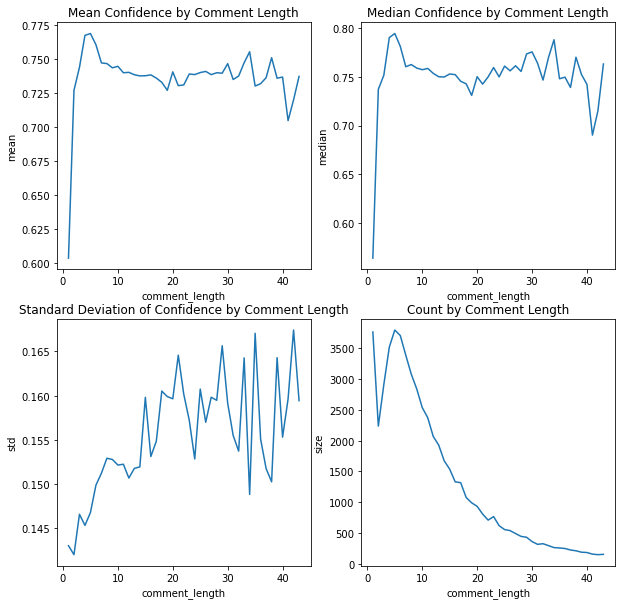

In [2]:
# Loading the dataframe
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns

df = pd.read_csv('data/all_comments_with_sentiment_scores.csv')

# Do longer comments have a higher confidence?
grouped_comment_length = df.groupby('comment_length')['score'].agg(['mean' , 'median' , 'std' , 'size'])

# Plotting
fig , ax = plt.subplots(2 , 2 , figsize = (10 , 10))

sns.lineplot(x = grouped_comment_length.index , y = grouped_comment_length['mean'] ,  ax = ax[0][0]).set_title('Mean Confidence by Comment Length')
sns.lineplot(x = grouped_comment_length.index , y = grouped_comment_length['median'] ,  ax = ax[0][1]).set_title('Median Confidence by Comment Length')
sns.lineplot(x = grouped_comment_length.index , y = grouped_comment_length['std'] ,  ax = ax[1][0]).set_title('Standard Deviation of Confidence by Comment Length')
sns.lineplot(x = grouped_comment_length.index , y = grouped_comment_length['size'] ,  ax = ax[1][1]).set_title('Count by Comment Length')

The model struggles with extremely short comments but predicts longer comments with a relatively stable level of confidence. It seems to have the most confidence when comments are around 5-10 words long.

#### Does the model predict any sentiment more confidently? 

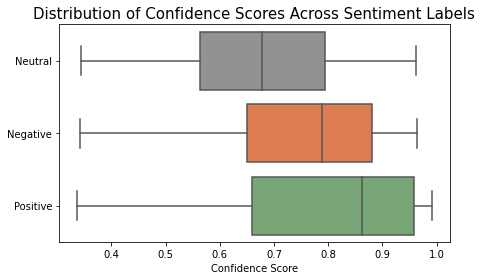

In [3]:
palette = ['#959094' , '#F4743B' , '#70AE6E' ]

# Creating the boxplot
plt.figure(figsize = (7, 4))
sns.boxplot(x = 'score' , y = 'label' , data = df, palette = palette)
plt.title('Distribution of Confidence Scores Across Sentiment Labels' , size = 15)
plt.xlabel('Confidence Score')
plt.ylabel('');

The median confidence score for Positive classifications is the highest but the distribution is left-skewed with the highest IQR of all three labels. We can't be certain that the model the model will always predict positive labels more confidently.

#### How many comments of each sentiment are present?

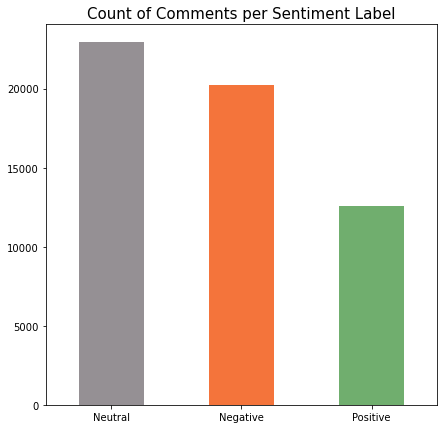

In [4]:
plt.figure(figsize = (7 , 7))
df.label.value_counts().plot(kind = 'bar' , color = palette)
plt.title('Count of Comments per Sentiment Label' , size = 15)
plt.xticks(rotation = 360);

### Calculating Weighted Sentiment Sentiment

After looking at the the distribution of confidence scores its clear that not all comments of the same sentiment label are of equal 'strength' and it makes sense to take confidence of the prediction into account when calculating a metric for sentiment.

I decided to create the metric 'weighted_sentiment'

Creating this metric will take two steps:

1. First I'll map each sentiment label to a numeric representation (-1 for Negative , 0.2 for Neutral , 1 for Postive).
2. Then, I will multiply this numeric representation by the respective confidence score (ranges from 0-1)

Ultimately, we will be left with a weighted sentiment score for each comment that takes the confidence into account. Confident negative predictions will approach -1 while confident positive predictions will approach 1.

In [5]:
# Creating a mapper
mapping_func = {'Positive' : 1,
               'Negative' : -1 ,
               'Neutral' : 0.2}

# Mapping the sentiment labels to numeric representations
df['sentiment_map'] = df['label'].map(mapping_func)

# Calculating weighted_sentiment
df['weighted_sentiment'] = df['sentiment_map'] * df['score']
df.head()

,Unnamed: 0,Video Id,comment,time,displayID,id,comment_length,label,score,sentiment_map,weighted_sentiment
0,1,DOtPOfeyJ4Q,Hes not scamming his sister probably got it fo...,2022-11-04T15:04:13Z,The guy who asked,UCNijoEJw5z3p4689tey5oYw,17,Neutral,0.647104,0.2,0.129421
1,2,DOtPOfeyJ4Q,He offered your money back definitely not a sc...,2022-11-04T14:57:57Z,F.B.I,UCXbuhDqmdm_M8UEOrQ77w6w,26,Neutral,0.533190,0.2,0.106638
2,3,DOtPOfeyJ4Q,Isn’t it hard authenticate a signature. If Kob...,2022-11-04T14:54:47Z,Olti Hajdaraj,UCPOYMbZKAIN39YFsvMTZ-Uw,21,Negative,0.509651,-1.0,-0.509651
3,4,DOtPOfeyJ4Q,"He answered the phone, definitely not trying t...",2022-11-04T14:49:10Z,Jordan,UCga1Isau1iPAlrezA6xoYSQ,13,Neutral,0.483931,0.2,0.096786
4,5,DOtPOfeyJ4Q,The seller has a legit point tho. At the end o...,2022-11-04T14:44:37Z,AkMac11,UCXOWvLzEwtlUubgZhXJI-Hw,17,Neutral,0.628328,0.2,0.125666


Text(0.5, 1.0, 'Weighted Sentiment Distribution')

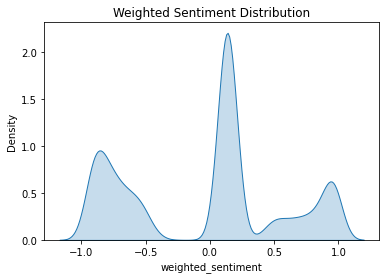

In [6]:
# Looking at the distribution of the new weighted sentiment variable
#plt.figure(figsize = (7,7))
sns.kdeplot(df['weighted_sentiment'] , fill = True)
plt.title('Weighted Sentiment Distribution', size = 12)

In [7]:
# saving the new df with weighted_sentiment_scores
df.to_csv('data/all_comments_with_sentiment_scores_weighted.csv')

### Diving deeper into the comment text

In [8]:
df = pd.read_csv('data/all_comments_with_sentiment_scores_weighted.csv')
df.drop(['Unnamed: 0.1' ,'Unnamed: 0' ], axis =1 , inplace = True)

#### Tokenize and lemmatize the comments

I'll use nltk to tokenize, lemmatize, and process the comments for further insight.

Tokenization is the process for seperating a sentence into smaller parts aka 'tokens' and Lemmatization is a method for grouping different forms of words into the same root form.

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
nltk.download('wordnet')
nltk.download('omw-1.4')
#from emot.emo_unicode import UNICODE_EMOJI


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\salaz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\salaz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
# Defining Stopwords (Words to ignore because they are common and dont add any insight)
stop_words = list(stopwords.words('english'))

other_stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
                   "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
                   "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", 
                   "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
                   "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", 
                   "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", 
                   "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
                   "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how",
                   "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not",
                   "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", 
                   "now",'anyone','today','yesterday','day', 'already' , 'the' , 'he', 'got', 'it' , 'isn' , 'video']
# single letters
letters = list(string.ascii_lowercase)

# Concatenate all stop words into one list
stop_words = stop_words + other_stop_words + letters

In [11]:
# defining the preporcessing function that will take in a comment, lowercase all uppercase letters , word tokenize, remove stopwords and non-alphabetic tokens, and lemmatize 
def preprocess_comment(comment):
    comment = comment.lower()
    comment_tokens = word_tokenize(comment)
    filtered_tokens = [word for word in comment_tokens if word not in stop_words]
    filtered_tokens = [word for word in comment_tokens if word.isalpha()]
    # Removing Punctuation
    filtered_tokens = [word for word in filtered_tokens if word not in string.punctuation]
    # Lemmatize the words
    WNL = WordNetLemmatizer()
    lemma_filtered_tokens = [WNL.lemmatize(w) for w in filtered_tokens]
    return " ".join(lemma_filtered_tokens)

In [12]:
# applying preprocessing to the comments
df['processed_comment'] = df['comment'].apply(preprocess_comment)

In [13]:
df.head()

,Video Id,comment,time,displayID,id,comment_length,label,score,sentiment_map,weighted_sentiment,processed_comment
0,DOtPOfeyJ4Q,Hes not scamming his sister probably got it fo...,2022-11-04T15:04:13Z,The guy who asked,UCNijoEJw5z3p4689tey5oYw,17,Neutral,0.647104,0.2,0.129421,he not scamming his sister probably got it for...
1,DOtPOfeyJ4Q,He offered your money back definitely not a sc...,2022-11-04T14:57:57Z,F.B.I,UCXbuhDqmdm_M8UEOrQ77w6w,26,Neutral,0.533190,0.2,0.106638,he offered your money back definitely not a sc...
2,DOtPOfeyJ4Q,Isn’t it hard authenticate a signature. If Kob...,2022-11-04T14:54:47Z,Olti Hajdaraj,UCPOYMbZKAIN39YFsvMTZ-Uw,21,Negative,0.509651,-1.0,-0.509651,isn t it hard authenticate a signature if kobe...
3,DOtPOfeyJ4Q,"He answered the phone, definitely not trying t...",2022-11-04T14:49:10Z,Jordan,UCga1Isau1iPAlrezA6xoYSQ,13,Neutral,0.483931,0.2,0.096786,he answered the phone definitely not trying to...
4,DOtPOfeyJ4Q,The seller has a legit point tho. At the end o...,2022-11-04T14:44:37Z,AkMac11,UCXOWvLzEwtlUubgZhXJI-Hw,17,Neutral,0.628328,0.2,0.125666,the seller ha a legit point tho at the end of ...


#### Creating Word Clouds for Postive and Negative comments

WordClouds are a great way to explore the differences between comments with positive and negative sentiments.

##### Postive Comments

In [14]:
# Subseting to positive comments
df_positive = df[df['label'] == 'Positive']

# Converting the processed comments to one long string to use as an argument for WordCloud
df_positive_tweets_long_string = " ".join(df_positive['processed_comment'].tolist())

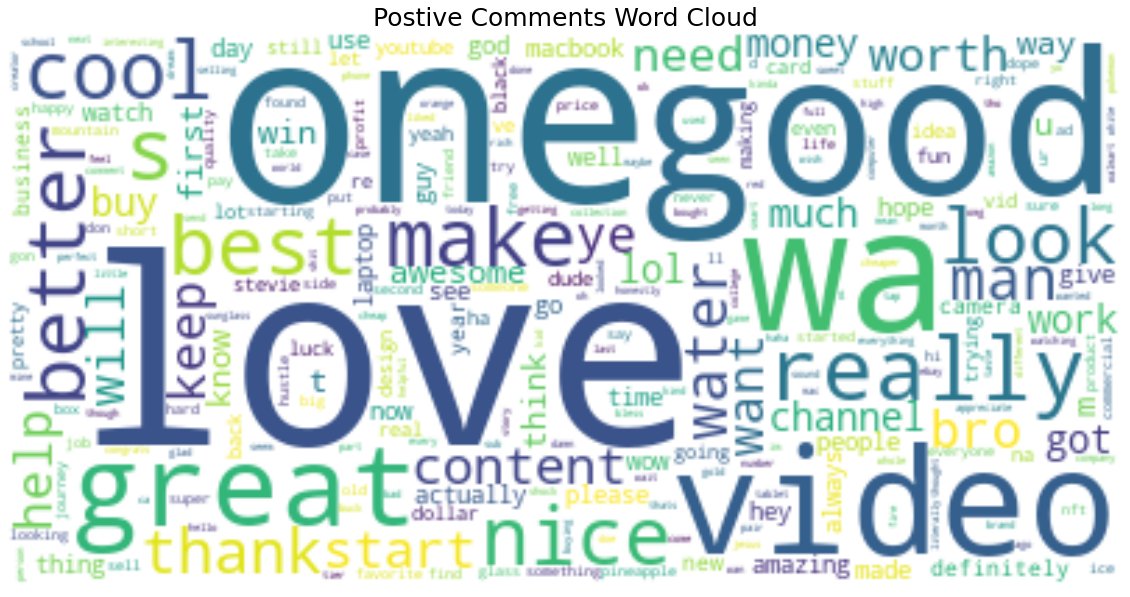

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Creating a WordCloud for positive sentiment comments
positive_wc = WordCloud(collocations = False,max_words=400 , background_color = 'white').generate(df_positive_tweets_long_string)

plt.figure(figsize = (20, 20))
plt.imshow(positive_wc, interpolation='bilinear')
plt.title('Postive Comments Word Cloud', size = 25)
plt.axis("off")
plt.show()

##### Negative Comments

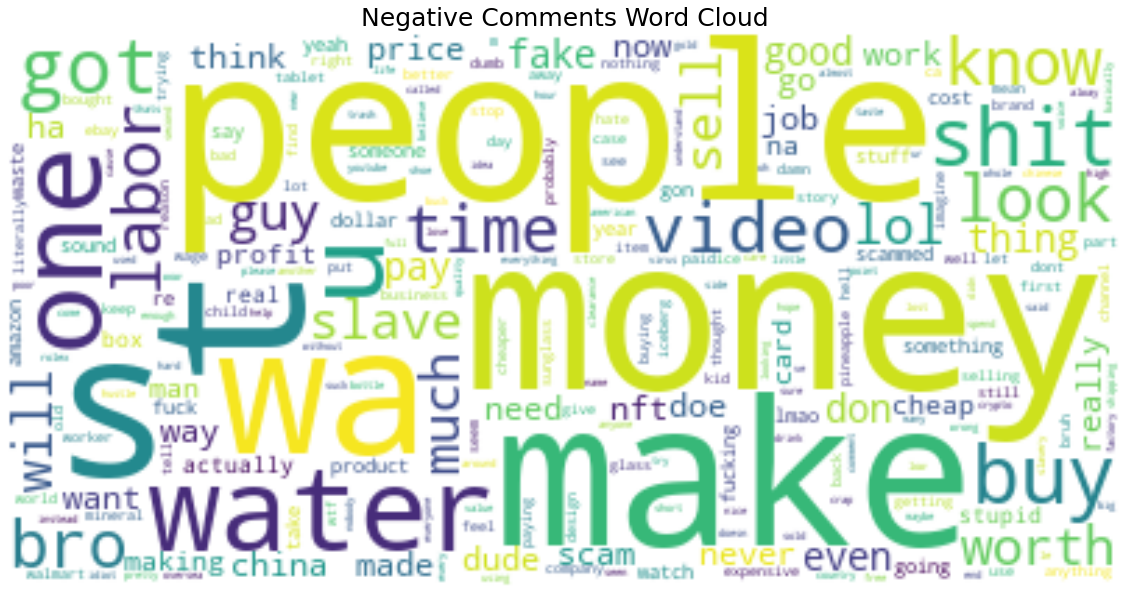

In [16]:
# Subseting to negative comments
df_negative= df[df['label'] == 'Negative']

# Converting the processed comments to one long string to use as an argument for WordCloud
df_negative_tweets_long_string = " ".join(df_negative['processed_comment'].tolist())

# Creating a WordCloud for negative sentiment comments
negative_wc = WordCloud(collocations = False,max_words=400 , background_color = 'white').generate(df_negative_tweets_long_string)

plt.figure(figsize = (20, 20))
plt.imshow(negative_wc, interpolation='bilinear')
plt.title('Negative Comments Word Cloud', size = 25)
plt.axis("off")
plt.show()

## Merging with Video_info DataFrame


### Aggregating the comments by video id

In order to merge the comment data with the higher level video data I will first need to group the comments by the video id field.

In [17]:
import pandas as pd
df = pd.read_csv('data/all_comments_with_sentiment_scores_weighted.csv')

# Grouping by Video Id and calculating the mean, median, std of weighted sentiment for each video
weighted_sentiment_agg_vid = df.groupby('Video Id')['weighted_sentiment'].agg(['mean' , 'median' , 'std'])
weighted_sentiment_agg_vid.reset_index(inplace = True)

In [18]:
weighted_sentiment_agg_vid = pd.DataFrame(weighted_sentiment_agg_vid)
weighted_sentiment_agg_vid

,Video Id,mean,median,std
0,-NeMQkXjzLQ,-0.066425,0.129703,0.550202
1,-hQCZGiwyUA,0.650249,0.909891,0.383607
2,0FXgNvNDqS8,0.287056,0.166229,0.518681
3,0JqbAZhncZ8,-0.213679,-0.600610,0.658120
4,0gJlInD47gw,-0.263380,-0.655285,0.685772
...,...,...,...,...
179,yYqWz-v9frA,-0.048377,0.129137,0.538907
180,ygsO-ExanEM,0.656781,0.916128,0.590811
181,z9MWIpKlhG8,-0.323747,-0.585163,0.560928
182,zKbnMJEpVkk,0.226797,0.150929,0.588072


**weighted_sentiment_agg_vid** is now ready to be merged with **video_info** on the Video Id column.

### Inspect the video_info dataframe

In [19]:
video_info = pd.read_csv('data/video_info.csv')

# Dropping the first column 'Unnamed: 0'
video_info.drop('Unnamed: 0' , axis = 1 , inplace = True)
video_info

,video_id,video_title,upload_date,view_count,like_count,comment_count
0,DOtPOfeyJ4Q,Confronting the seller of a questionable Kobe ...,2022-11-02,781610,62761,447
1,ZrZVTAdSMl8,Do experts think my cheap Kobe autograph is real?,2022-11-01,113539,9483,57
2,_DcZFOirIDE,Anyone need a new camera?,2022-11-01,40723,3162,3230
3,JVHboSk65-k,I asked collectors if my cheap Kobe autographs...,2022-10-31,971564,78562,70
4,nxy-A8auW9U,Unboxing a $400 Kobe autographed ball (real?),2022-10-28,501415,46803,70
...,...,...,...,...,...,...
179,G64RvvjWadc,9 Side Hustles That Are Slept On In 2021 ($200...,2021-05-27,3058,175,9
180,qlPG818l_Yc,I Tried Dropshipping A Dollar Tree Product (72...,2021-04-30,2206,95,10
181,GKgZiqBsxds,Zero To 500k On Facebook In 1 Year | Full Step...,2021-03-30,1080,81,10
182,Kxxxtkioncc,I Tried Dropshipping From Scratch (24HR CHALLE...,2021-03-10,7339,397,55


This dataframe contains the **video title** , **upload_date** , **view_count** , **like_count** ,  and **total comment count**. Merging the sentiment data could lead to some interesting insights into how the overall sentiment of comments on a video might impact view count or comment count.

### Merging with two datasets

In [20]:
video_info_with_sentiment = video_info.merge(right = weighted_sentiment_agg_vid ,how = 'inner'  , left_on = 'video_id' , right_on = 'Video Id')
video_info_with_sentiment.shape

(184, 10)

The merged dataframe has 10 columns as expected but we will need to drop one of the video id columns

#### Cleaning the merged df

In [21]:
# The merged dataframe has 10 columns as expected but we will need to drop one of the video id columns
video_info_with_sentiment.drop('Video Id' , axis = 1 , inplace = True)

# Renaming the columns mean , median , and std columns
video_info_with_sentiment.rename({
    'mean' : 'mean_weighted_sentiment_score',
    'median' : 'median_weighted_sentiment_score',
    'std' : 'std_weighted_sentiment_score'
}, axis = 1 , inplace = True)


#### Dropping videos with less than 30 comments

Looking at some of the rows I noticed that many of the earlier videos had fewer comments. I decided to set a threshold for the number of comments and will not include videos with less than 30 comments in my analysis. 

In [22]:
num_comments_threshold = video_info_with_sentiment['comment_count'].quantile(0.20)
video_info_with_sentiment = video_info_with_sentiment[video_info_with_sentiment['comment_count'] >= num_comments_threshold]
video_info_with_sentiment.shape

(147, 9)

#### Turning the mean weighted sentiment score for each video into a label

A video will be labeled as 'Positive' if the mean_weighted_sentiment_score >= 0.1 , 'Negative' if the mean_weighted_sentiment_score <= -0.1, and 'Neutral' if the mean_weighted_sentiment_score is between -0.1 and 0.1

In [23]:
def sentiment_category(sentiment_score):
    if sentiment_score >= 0.1:
        return 'Positive'
    elif sentiment_score <= -0.1:
        return 'Negative'
    else:
        return 'Neutral'

In [24]:
video_info_with_sentiment['sentiment_label'] = video_info_with_sentiment['mean_weighted_sentiment_score'].apply(sentiment_category)

In [25]:
video_info_with_sentiment.sentiment_label.value_counts()

Positive    55
Negative    52
Neutral     40
Name: sentiment_label, dtype: int64

In [26]:
# saving the new video_info df with sentiment scores/labels
video_info_with_sentiment.to_csv('data/video_info_with_sentiment.csv')

### Visualizations

In [27]:
import pandas as pd
video_info_with_sentiment = pd.read_csv('data/video_info_with_sentiment.csv')
video_info_with_sentiment.columns

Index(['Unnamed: 0', 'video_id', 'video_title', 'upload_date', 'view_count',
       'like_count', 'comment_count', 'mean_weighted_sentiment_score',
       'median_weighted_sentiment_score', 'std_weighted_sentiment_score',
       'sentiment_label'],
      dtype='object')

#### Sentiment Score and View Count

C:\Users\salaz\anaconda3\envs\youtube_comments_project\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


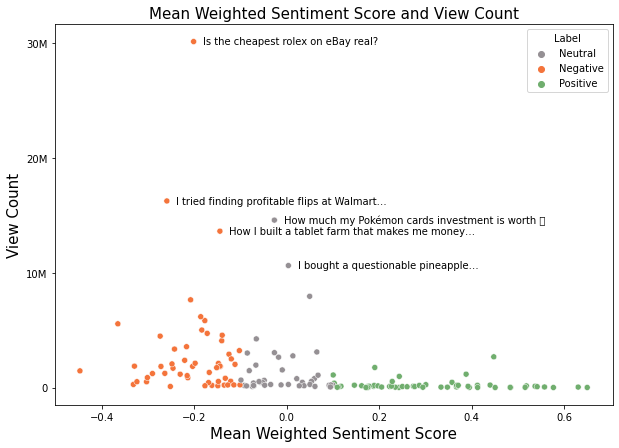

In [28]:
#fig = px.scatter(video_info_with_sentiment , x = 'mean_weighted_sentiment_score' , y = 'view_count' , color = 'sentiment_label', hover_data = ['video_title' , 'comment_count' , 'upload_date' , 'video_id'] , title= 'Mean Weighted Sentiment Score and View Count')
#fig.show()
import numpy as np
plt.figure(figsize= (10 , 7))
hue_order = ['Neutral' , 'Negative' , 'Positive']
ax = sns.scatterplot(data = video_info_with_sentiment , x = 'mean_weighted_sentiment_score' , y = 'view_count' , hue = 'sentiment_label' , palette = palette , hue_order=hue_order)
plt.title("Mean Weighted Sentiment Score and View Count" , size = 15)
plt.ylabel("View Count" , size = 15)
plt.xlabel("Mean Weighted Sentiment Score", size = 15)
plt.legend(title = "Label")
plt.yticks(ticks = [0 , 10000000 , 20000000 , 30000000] , labels = ["0" , "10M" , "20M" , "30M"])


idx = video_info_with_sentiment['view_count'] > 10000000
for i,row in video_info_with_sentiment.loc[idx].iterrows():
  ax.annotate(row["video_title"],
                xy = (row["mean_weighted_sentiment_score"] + 0.02 ,row["view_count"]),
                xycoords='data',
                horizontalalignment='left' ,verticalalignment='center' , fontsize = 10,
                );

It's interesting to see that videos with a Positive sentiment did not perform as well (in terms of views) when compared to videos with a Negative sentiment of a similar magnitude. The distributions are of sentiment are likely skewed and it makes sense to inspect the median as well.

C:\Users\salaz\anaconda3\envs\youtube_comments_project\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


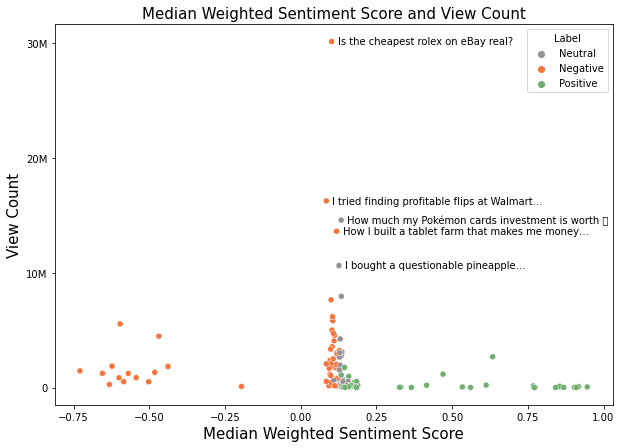

In [29]:
#fig = px.scatter(video_info_with_sentiment , x = 'median_weighted_sentiment_score' , y = 'view_count' , color = 'sentiment_label', hover_data = ['video_title' , 'comment_count' , 'upload_date' , 'video_id'] , title= 'Median Weighted Sentiment Score and View Count')
#fig.show()

plt.figure(figsize= (10 , 7))
ax = sns.scatterplot(data = video_info_with_sentiment , x = 'median_weighted_sentiment_score' , y = 'view_count' , hue = 'sentiment_label' , palette = palette , hue_order=hue_order)
plt.title("Median Weighted Sentiment Score and View Count" , size = 15)
plt.ylabel("View Count" , size = 15)
plt.xlabel("Median Weighted Sentiment Score", size = 15)
plt.legend(title = "Label")
plt.yticks(ticks = [0 , 10000000 , 20000000 , 30000000] , labels = ["0" , "10M" , "20M" , "30M"])


idx = video_info_with_sentiment['view_count'] > 10000000
for i,row in video_info_with_sentiment.loc[idx].iterrows():
  ax.annotate(row["video_title"],
                xy = (row["median_weighted_sentiment_score"] + 0.02 ,row["view_count"]),
                xycoords='data',
                horizontalalignment='left' ,verticalalignment='center' , fontsize = 10,
                );

The trend is less obvious but we can still see that videos with a Positive sentiment did not perform as well as those with a Negative sentiment of a similar magnitude.

#### Sentiment Score and Comment Count

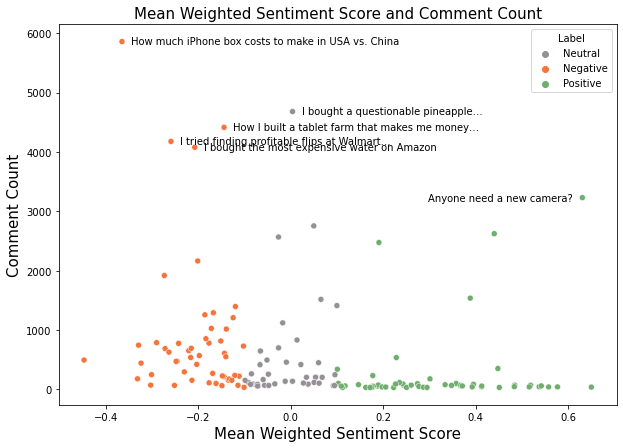

In [30]:
#fig = px.scatter(video_info_with_sentiment , x = 'mean_weighted_sentiment_score' , y = 'comment_count' , color = 'sentiment_label', hover_data = ['video_title' , 'comment_count' , 'upload_date' , 'video_id'] , title= 'Mean Weighted Sentiment Score and Comment Count')
#fig.show()
plt.figure(figsize= (10 , 7))
ax = sns.scatterplot(data = video_info_with_sentiment , x = 'mean_weighted_sentiment_score' , y = 'comment_count' , hue = 'sentiment_label' , palette = palette , hue_order=hue_order)
plt.title("Mean Weighted Sentiment Score and Comment Count" , size = 15)
plt.ylabel("Comment Count" , size = 15)
plt.xlabel("Mean Weighted Sentiment Score", size = 15)
plt.legend(title = "Label")
#plt.yticks(ticks = [0 , 10000000 , 20000000 , 30000000] , labels = ["0" , "10M" , "20M" , "30M"])


idx = video_info_with_sentiment['comment_count'] > 3000
for i,row in video_info_with_sentiment.loc[idx].iterrows():
  ax.annotate(row["video_title"],
                xy = (row["mean_weighted_sentiment_score"] + 0.02 ,row["comment_count"]) if row['mean_weighted_sentiment_score'] < 0.4 
                      else (row["mean_weighted_sentiment_score"] - 0.02 ,row["comment_count"]),
                xycoords='data',
                horizontalalignment= 'left' if row['mean_weighted_sentiment_score'] < 0.4 else 'right',verticalalignment='center' , fontsize = 10,
                );

## Finiding Average Comments/day and Average Views/day for Negative and Positive Sentiment Videos

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

comments_df = pd.read_csv('data/all_comments_with_sentiment_scores_weighted.csv')
video_info = pd.read_csv('data/video_info_with_sentiment.csv')

comments_df['time'] = pd.to_datetime(comments_df['time'])

# Finding the date that the data was extracted
max_date = comments_df['time'].max().date()
print(f"The most recent date that comments were extracted was {max_date}")

The most recent date that comments were extracted was 2022-11-04


In [38]:
video_info['upload_date'] = pd.to_datetime(video_info['upload_date'])
video_info['max_date'] = pd.to_datetime(max_date)

# Finding the number of days that have passed since a video was uploaded to YouTube
video_info['days_since_upload'] = (video_info['max_date'] - video_info['upload_date']) / np.timedelta64(1, 'D')

# Dropping the max_date column (it was only needed to calculate days since a video was uploaded)
video_info.drop('max_date' , axis = 1 , inplace = True)

# Finding views per day
video_info['views_per_day'] = round(video_info['view_count'] / video_info['days_since_upload'] ,2)

# Finding comments per day
video_info['comment_count_per_day'] = round(video_info['comment_count'] / video_info['days_since_upload'],2)

In [60]:
# Finding the mean and median views per day across each sentiment label
views_per_day_grouped = video_info.groupby('sentiment_label')['views_per_day'].agg(['mean' , 'median'])

In [45]:
# Finding the mean and median comments per day across each sentiment label
video_info.groupby('sentiment_label')['comment_count_per_day'].agg(['mean' , 'median'])

,mean,median
sentiment_label,,
Negative,7.235192,4.165
Neutral,10.499750,1.885
Positive,22.766909,0.380


### Visualizations

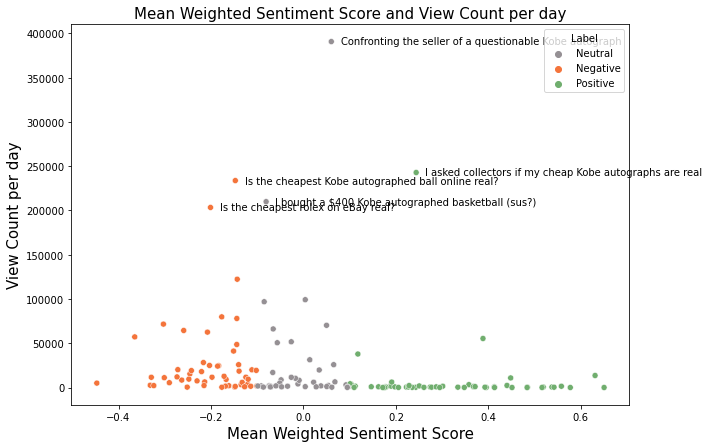

In [49]:
palette = ['#959094' , '#F4743B' , '#70AE6E' ]
hue_order = ['Neutral' , 'Negative' , 'Positive']

plt.figure(figsize= (10 , 7))
ax = sns.scatterplot(data = video_info , x = 'mean_weighted_sentiment_score' , y = 'views_per_day' , hue = 'sentiment_label' , palette = palette , hue_order=hue_order)
plt.title("Mean Weighted Sentiment Score and View Count per day" , size = 15)
plt.ylabel("View Count per day" , size = 15)
plt.xlabel("Mean Weighted Sentiment Score", size = 15)
plt.legend(title = "Label")
#plt.yticks(ticks = [0 , 10000000 , 20000000 , 30000000] , labels = ["0" , "10M" , "20M" , "30M"])


idx = video_info['views_per_day'] > 200000
for i,row in video_info.loc[idx].iterrows():
  ax.annotate(row["video_title"],
                xy = (row["mean_weighted_sentiment_score"] + 0.02 ,row["views_per_day"]),
                xycoords='data',
                horizontalalignment='left' ,verticalalignment='center' , fontsize = 10,
                );

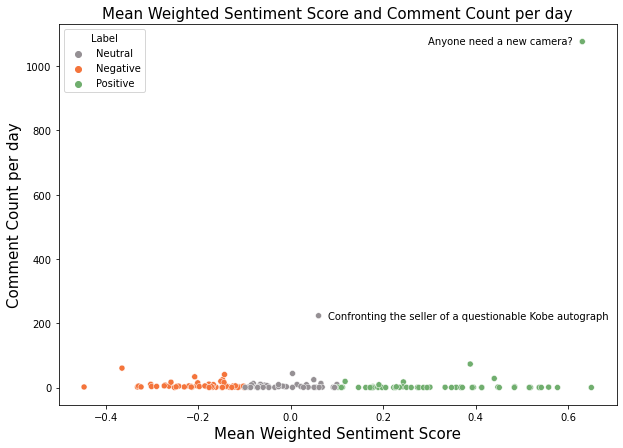

In [52]:
plt.figure(figsize= (10 , 7))
ax = sns.scatterplot(data = video_info , x = 'mean_weighted_sentiment_score' , y = 'comment_count_per_day' , hue = 'sentiment_label' , palette = palette , hue_order=hue_order)
plt.title("Mean Weighted Sentiment Score and Comment Count per day" , size = 15)
plt.ylabel("Comment Count per day" , size = 15)
plt.xlabel("Mean Weighted Sentiment Score", size = 15)
plt.legend(title = "Label")
#plt.yticks(ticks = [0 , 10000000 , 20000000 , 30000000] , labels = ["0" , "10M" , "20M" , "30M"])


idx = video_info['comment_count_per_day'] > 200
for i,row in video_info.loc[idx].iterrows():
  ax.annotate(row["video_title"],
                xy = (row["mean_weighted_sentiment_score"] + 0.02 ,row["comment_count_per_day"]) if row['mean_weighted_sentiment_score'] < 0.4 
                      else (row["mean_weighted_sentiment_score"] - 0.02 ,row["comment_count_per_day"]),
                xycoords='data',
                horizontalalignment= 'left' if row['mean_weighted_sentiment_score'] < 0.4 else 'right',verticalalignment='center' , fontsize = 10,
                );

The video "Anyone need a new camera" is an obvious outlier that explains why the mean comment count per day is so much higher than the median. 

In [66]:
video_info_no_outlier = video_info[video_info['comment_count_per_day'] < 1000]
#print(video_info_no_outlier.shape , video_info.shape)

# Recalculating mean/median comments per day across the sentiment labels
comments_per_day_grouped = video_info_no_outlier.groupby('sentiment_label')['comment_count_per_day'].agg(['mean' , 'median'])
comments_per_day_grouped , views_per_day_grouped

(                      mean  median
 sentiment_label                   
 Negative          7.235192   4.165
 Neutral          10.499750   1.885
 Positive          3.250185   0.350,
                          mean    median
 sentiment_label                        
 Negative         28507.405385  11640.38
 Neutral          30388.169500   3511.90
 Positive          7403.396727    551.89)

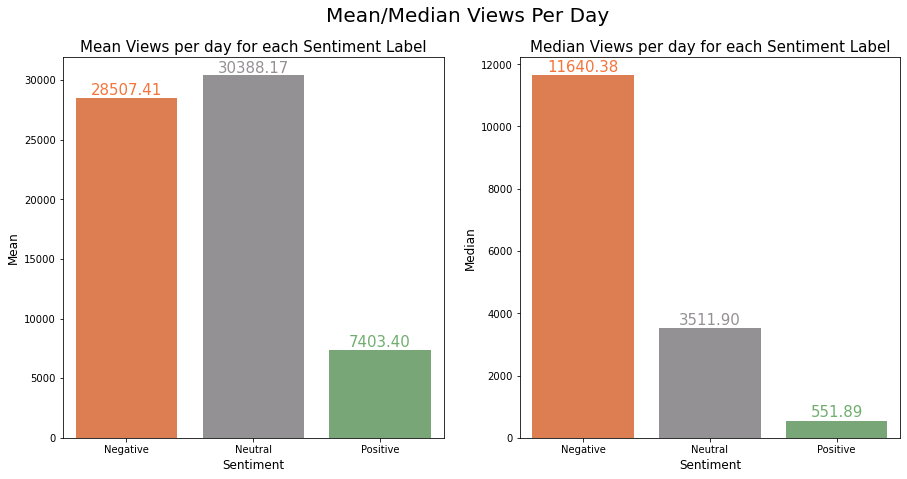

In [104]:
palette = ['#F4743B' , '#959094' , '#70AE6E' ]
hue_order = ['Negative' , 'Neutral' , 'Positive']

fig , ax = plt.subplots(1 ,2, figsize = (15 , 7))
sns.barplot(data = views_per_day_grouped , x = comments_per_day_grouped.index , y = 'mean' , palette = palette , hue_order = hue_order , ax = ax[0]).set_title("Mean Views per day for each Sentiment Label" , size = 15)
ax[0].set_xlabel('Sentiment' , size = 12)
ax[0].set_ylabel('Mean' , size = 12)

# Annotating the Positive and Negative sentiment bars
for i , bar in enumerate(ax[0].patches):
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    ax[0].annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 200), ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points', color = palette[i])


sns.barplot(data = views_per_day_grouped , x = views_per_day_grouped.index , y = 'median' , palette = palette , hue_order = hue_order , ax = ax[1]).set_title("Median Views per day for each Sentiment Label" , size = 15)
ax[1].set_xlabel('Sentiment' , size = 12)
ax[1].set_ylabel('Median' , size = 12)

# Annotating the sentiment bars
for i , bar in enumerate(ax[1].patches):
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    ax[1].annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 100), ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points', color = palette[i])
    
fig.suptitle('Mean/Median Views Per Day' , size = 20);

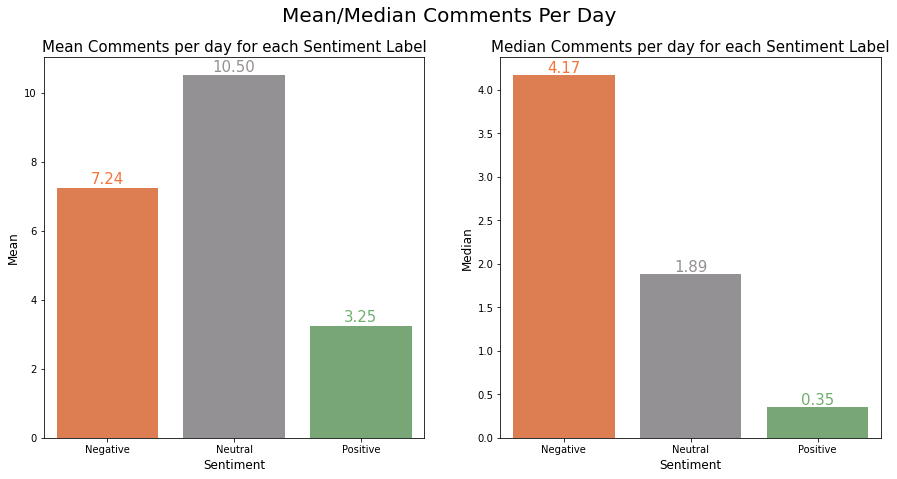

In [111]:
palette = ['#F4743B' , '#959094' , '#70AE6E' ]
hue_order = ['Negative' , 'Neutral' , 'Positive']

fig , ax = plt.subplots(1 ,2, figsize = (15 , 7))
sns.barplot(data = comments_per_day_grouped , x = comments_per_day_grouped.index , y = 'mean' , palette = palette , hue_order = hue_order , ax = ax[0]).set_title("Mean Comments per day for each Sentiment Label" , size = 15)
ax[0].set_xlabel('Sentiment' , size = 12)
ax[0].set_ylabel('Mean' , size = 12)

# Annotating the Positive and Negative sentiment bars
for i , bar in enumerate(ax[0].patches):
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    ax[0].annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height() +0.1), ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points', color = palette[i])


sns.barplot(data = comments_per_day_grouped , x = comments_per_day_grouped.index , y = 'median' , palette = palette , hue_order = hue_order , ax = ax[1]).set_title("Median Comments per day for each Sentiment Label" , size = 15)
ax[1].set_xlabel('Sentiment' , size = 12)
ax[1].set_ylabel('Median' , size = 12)

# Annotating the sentiment bars
for i , bar in enumerate(ax[1].patches):
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    ax[1].annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.02), ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points', color = palette[i])
    
fig.suptitle('Mean/Median Comments Per Day' , size = 20);

Text(0.5, 1.0, 'Distribution of Comments per day for each Sentiment Label')

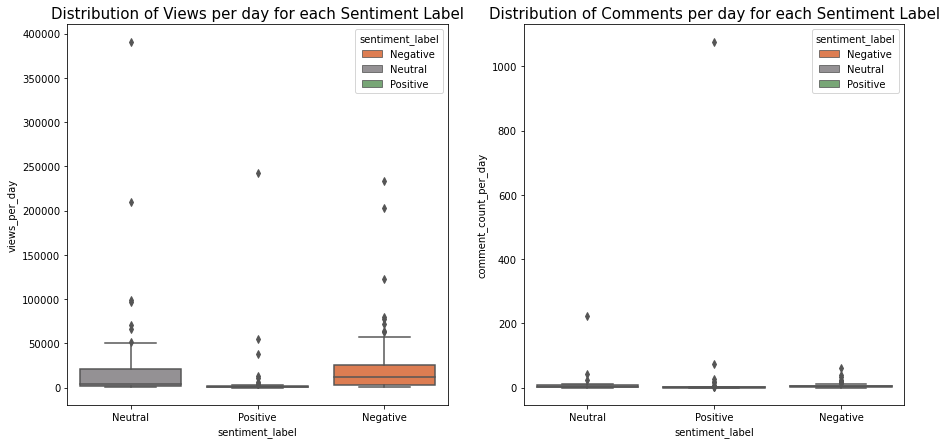

In [133]:
# Using a boxplot to show the true distribution behind the mean/median
fig , ax = plt.subplots(1 ,2, figsize = (15 , 7))
sns.boxplot(data = video_info , x = 'sentiment_label', y = 'views_per_day' , palette = palette , hue = 'sentiment_label', hue_order = hue_order , ax = ax[0] , dodge =False).set_title("Distribution of Views per day for each Sentiment Label" , size = 15)
sns.boxplot(data = video_info , x = 'sentiment_label', y = 'comment_count_per_day' , palette = palette , hue = 'sentiment_label', hue_order = hue_order , ax = ax[1], dodge =False).set_title("Distribution of Comments per day for each Sentiment Label" , size = 15)


In [124]:
video_info.to_csv('data/video_info_with_sentiment.csv')

## Conclusion and Next Steps

In [120]:
# Finding the Ratio for Positive vs. Negative Sentiment
mean_views_ratio = round(views_per_day_grouped.loc['Negative' , 'mean'] / views_per_day_grouped.loc['Positive' , 'mean'], 2)
mean_comments_ratio = round(comments_per_day_grouped.loc['Negative' , 'mean'] / comments_per_day_grouped.loc['Positive' , 'mean'], 2)

median_views_ratio = round(views_per_day_grouped.loc['Negative' , 'median'] / views_per_day_grouped.loc['Positive' , 'median'], 2)
median_comments_ratio = round(comments_per_day_grouped.loc['Negative' , 'median'] / comments_per_day_grouped.loc['Positive' , 'median'], 2)

print(f"Videos with an overall Negative comment sentiment averaged {mean_views_ratio}X more views per day and {mean_comments_ratio}X more comments per day than those with an overall Positive Sentiment")

print(f"The median views per day was {median_views_ratio}X higher and the median comments per day was {median_comments_ratio}X higher")

Videos with an overall Negative comment sentiment averaged 3.85X more views per day and 2.23X more comments per day than those with an overall Positive Sentiment
The median views per day was 21.09X higher and the median comments per day was 11.9X higher


Some next steps/future projects could be:

- Topic identification for the comments
- Analyzing the full distribution of sentiment scores for the highest performing videos
- Bot detection?

[Tableau Dashboard for this project](https://public.tableau.com/views/SentimentAnalysisDashboard_16694102080060/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)